# Scalable Model Compression: https://www.tensorflow.org/tutorials/optimization/compression

In [2]:
# Installs the latest version of TFC compatible with the installed TF version.

import subprocess
import re

result = subprocess.run(['pip', 'show', 'tensorflow'], capture_output=True, text=True)
match = re.search(r'Version: (\d+)\.(\d+)', result.stdout)

if match:
    MAJOR = match.group(1)
    MINOR = int(match.group(2))
    pip_install_command = f'pip install "tensorflow-compression<{MAJOR}.{MINOR + 1}"'
    print(pip_install_command)
    subprocess.run(pip_install_command, shell=True) #Use shell=True with caution
else:
    print("Could not determine TensorFlow version.")

pip install "tensorflow-compression<2.19"


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

In [4]:
# Define custom layers to later suclass and compress
class CustomDense(tf.keras.layers.Layer):

  def __init__(self, filters, name="dense"):
    super().__init__(name=name)
    self.filters = filters

  @classmethod
  def copy(cls, other, **kwargs):
    self = cls(filters=other.filters, name=other.name, **kwargs)
    self.build(None, other=other)
    return self

  def build(self, input_shape, other=None):
    if other is None:
      kernel_shape = (input_shape[-1], self.filters)
      kernel = tf.keras.initializers.GlorotUniform()(shape=kernel_shape)
      bias = tf.keras.initializers.Zeros()(shape=(self.filters,))
    else:
      kernel, bias = other.kernel, other.bias
    self.kernel = tf.Variable(tf.cast(kernel, self.variable_dtype), name="kernel")
    self.bias = tf.Variable(tf.cast(bias, self.variable_dtype), name="bias")
    self.built = True

  def call(self, inputs):
    outputs = tf.linalg.matvec(self.kernel, inputs, transpose_a=True)
    outputs = tf.nn.bias_add(outputs, self.bias)
    return tf.nn.leaky_relu(outputs)

In [5]:
class CustomConv2D(tf.keras.layers.Layer):

  def __init__(self, filters, kernel_size, strides=1, padding="SAME", name="conv2d"):
    super().__init__(name=name)
    self.filters = filters
    self.kernel_size = kernel_size
    self.strides = strides
    self.padding = padding

  @classmethod
  def copy(cls, other, **kwargs):
    self = cls(filters=other.filters, kernel_size=other.kernel_size,
               strides=other.strides, padding=other.padding,
               name=other.name, **kwargs)
    self.build(None, other=other)
    return self

  def build(self, input_shape, other=None):
    if other is None:
      kernel_shape = 2 * (self.kernel_size, ) + (input_shape[-1], self.filters)
      kernel = tf.keras.initializers.GlorotUniform()(shape=kernel_shape)
      bias = tf.keras.initializers.Zeros()(shape=(self.filters,))
    else:
      kernel, bias = other.kernel, other.bias
    self.kernel = tf.Variable(tf.cast(kernel, self.variable_dtype), name="kernel")
    self.bias = tf.Variable(tf.cast(bias, self.variable_dtype), name="bias")
    self.built = True

  def call(self, inputs):
    outputs = tf.nn.convolution(inputs, self.kernel, strides=self.strides, padding=self.padding)
    outputs=  tf.nn.bias_add(outputs, self.bias)
    return tf.nn.leaky_relu(outputs)

In [6]:
# Train a regular classifier
classifier = tf.keras.Sequential([
    CustomConv2D(20, 5, strides=2, name="conv_1"),
    CustomConv2D(50, 5, strides=2, name="conv_2"),
    tf.keras.layers.Flatten(),
    CustomDense(500, name="fc_1"),
    CustomDense(10, name="fc_2"),
], name="classifier")

In [7]:
def normalise_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False
)
training_dataset = training_dataset.map(normalise_img)
validation_dataset = training_dataset.map(normalise_img)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [8]:
def train_model(model, training_data, validation_data, **kwargs):
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(
      training_data.batch(128).prefetch(8),
      validation_data=validation_data.batch(128).cache(),
      validation_freq=1,
      **kwargs
  )
  return log.history["val_sparse_categorical_accuracy"][-1]

classifier_accuracy = train_model(classifier, training_dataset, validation_dataset)
print(f"Accuracy: {classifier_accuracy:0.4f}")

Epoch 1/5
469/469 [==============================] - 297s 629ms/step - loss: 0.2100 - sparse_categorical_accuracy: 0.9370 - val_loss: 2.2849 - val_sparse_categorical_accuracy: 0.1721
Epoch 2/5
469/469 [==============================] - 280s 597ms/step - loss: 0.0637 - sparse_categorical_accuracy: 0.9807 - val_loss: 2.3017 - val_sparse_categorical_accuracy: 0.1211
Epoch 3/5
469/469 [==============================] - 279s 595ms/step - loss: 0.0432 - sparse_categorical_accuracy: 0.9870 - val_loss: 2.3114 - val_sparse_categorical_accuracy: 0.1171
Epoch 4/5
469/469 [==============================] - 277s 592ms/step - loss: 0.0311 - sparse_categorical_accuracy: 0.9905 - val_loss: 2.3164 - val_sparse_categorical_accuracy: 0.0975
Epoch 5/5
469/469 [==============================] - 284s 607ms/step - loss: 0.0250 - sparse_categorical_accuracy: 0.9923 - val_loss: 2.3250 - val_sparse_categorical_accuracy: 0.0975
Accuracy: 0.0975


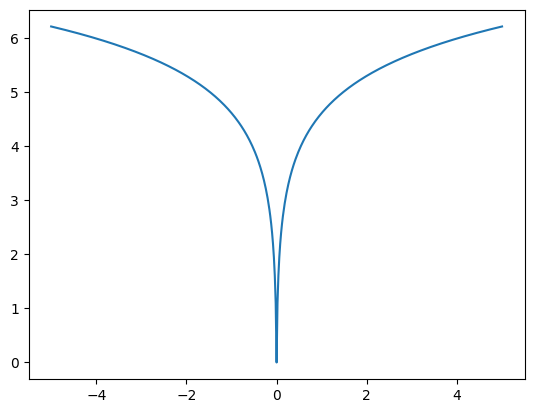

In [9]:
# Penalise weights according to entropy
_ = tf.linspace(-5., 5., 501)
plt.plot(_, tfc.PowerLawEntropyModel(0).penalty(_))

In [11]:
class PowerLawRegularizer(tf.keras.regularizers.Regularizer):

  def __init__(self, lmbda):
    super().__init__()
    self.lmbda = lmbda

  def __call__(self, variable):
    em = tfc.PowerLawEntropyModel(coding_rank=variable.shape.rank)
    return self.lmbda * em.penalty(variable)

regularizer = PowerLawRegularizer(lmbda=2./classifier.count_params())

In [12]:
def quantize(latent, log_step):
  step = tf.exp(log_step)
  return tfc.round_st(latent / step) * step

In [13]:
class CompressibleDense(CustomDense):

  def __init__(self, regularizer, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.regularizer = regularizer

  def build(self, input_shape, other=None):
    super().build(input_shape, other=None)
    if other is not None and hasattr(other, "kernel_log_setp"):
      kernel_log_step = other.kernel_log_step
      bias_log_step = other.bias_log_step
    else:
      kernel_log_step = bias_log_step = -4

    self.kernel_log_step = tf.Variable(tf.cast(kernel_log_step, self.variable_dtype), name="kernel_log_step")
    self.bias_log_step = tf.Variable(tf.cast(bias_log_step, self.variable_dtype), name="bias_log_step")
    self.add_loss(lambda: self.regularizer(self.kernel_latent / tf.exp(self.kernel_log_step)))
    self.add_loss(lambda: self.regularizer(self.bias_latent / tf.exp(self.bias_log_step)))

  @property
  def kernel(self):
    return quantize(self.kernel_latent, self.kernel_log_step)

  @kernel.setter
  def kernel(self, kernel):
    self.kernel_latent = tf.Variable(kernel, name="kernel_latent")

  @property
  def bias(self):
    return quantize(self.bias_latent, self.bias_log_step)

  @bias.setter
  def bias(self, bias):
    self.bias_latent = tf.Variable(bias, name="bias_latent")


In [14]:
# Store convolution kernel as a real-valued discrete Fourier transform
def to_rdft(kernel, kernel_size):
  # The kernel has shape (H, W, I, O) -> transpose to take DFT over last two
  # dimensions.
  kernel = tf.transpose(kernel, (2, 3, 0, 1))
  # The RDFT has type complex64 and shape (I, O, FH, FW).
  kernel_rdft = tf.signal.rfft2d(kernel)
  # Map real and imaginary parts into regular floats. The result is float32
  # and has shape (I, O, FH, FW, 2).
  kernel_rdft = tf.stack(
      [tf.math.real(kernel_rdft), tf.math.imag(kernel_rdft)], axis=-1)
  # Divide by kernel size to make the DFT orthonormal (length-preserving).
  return kernel_rdft / kernel_size

def from_rdft(kernel_rdft, kernel_size):
  # Undoes the transformations in to_rdft.
  kernel_rdft *= kernel_size
  kernel_rdft = tf.dtypes.complex(*tf.unstack(kernel_rdft, axis=-1))
  kernel = tf.signal.irfft2d(kernel_rdft, fft_length=2 * (kernel_size,))
  return tf.transpose(kernel, (2, 3, 0, 1))

In [15]:
class CompressibleConv2D(CustomConv2D):

  def __init__(self, regularizer, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.regularizer = regularizer

  def build(self, input_shape, other=None):
    """Instantiates weights, optionally initializing them from `other`."""
    super().build(input_shape, other=other)
    if other is not None and hasattr(other, "kernel_log_step"):
      kernel_log_step = other.kernel_log_step
      bias_log_step = other.bias_log_step
    else:
      kernel_log_step = tf.fill(self.kernel_latent.shape[2:], -4.)
      bias_log_step = -4.
    self.kernel_log_step = tf.Variable(
        tf.cast(kernel_log_step, self.variable_dtype), name="kernel_log_step")
    self.bias_log_step = tf.Variable(
        tf.cast(bias_log_step, self.variable_dtype), name="bias_log_step")
    self.add_loss(lambda: self.regularizer(
        self.kernel_latent / tf.exp(self.kernel_log_step)))
    self.add_loss(lambda: self.regularizer(
        self.bias_latent / tf.exp(self.bias_log_step)))

  @property
  def kernel(self):
    kernel_rdft = quantize(self.kernel_latent, self.kernel_log_step)
    return from_rdft(kernel_rdft, self.kernel_size)

  @kernel.setter
  def kernel(self, kernel):
    kernel_rdft = to_rdft(kernel, self.kernel_size)
    self.kernel_latent = tf.Variable(kernel_rdft, name="kernel_latent")

  @property
  def bias(self):
    return quantize(self.bias_latent, self.bias_log_step)

  @bias.setter
  def bias(self, bias):
    self.bias_latent = tf.Variable(bias, name="bias_latent")

In [16]:
# Same classifier model, but using compressed layers
def make_mnist_classifier(regularizer):
  return tf.keras.Sequential([
      CompressibleConv2D(regularizer, 20, 5, strides=2, name="conv_1"),
      CompressibleConv2D(regularizer, 50, 5, strides=2, name="conv_2"),
      tf.keras.layers.Flatten(),
      CompressibleDense(regularizer, 500, name="fc_1"),
      CompressibleDense(regularizer, 10, name="fc_2"),
  ], name="classifier")

compressible_classifier = make_mnist_classifier(regularizer)

In [17]:
penalized_accuracy = train_model(
    compressible_classifier, training_dataset, validation_dataset)

print(f"Accuracy: {penalized_accuracy:0.4f}")

Epoch 1/5
469/469 [==============================] - 327s 690ms/step - loss: 3.8429 - sparse_categorical_accuracy: 0.9294 - val_loss: 4.3908 - val_sparse_categorical_accuracy: 0.0914
Epoch 2/5
469/469 [==============================] - 297s 634ms/step - loss: 1.6758 - sparse_categorical_accuracy: 0.9762 - val_loss: 3.5362 - val_sparse_categorical_accuracy: 0.0904
Epoch 3/5
469/469 [==============================] - 297s 634ms/step - loss: 1.0804 - sparse_categorical_accuracy: 0.9826 - val_loss: 3.2096 - val_sparse_categorical_accuracy: 0.0904
Epoch 4/5
469/469 [==============================] - 299s 638ms/step - loss: 0.8025 - sparse_categorical_accuracy: 0.9862 - val_loss: 3.0361 - val_sparse_categorical_accuracy: 0.0904
Epoch 5/5
469/469 [==============================] - 298s 636ms/step - loss: 0.6646 - sparse_categorical_accuracy: 0.9874 - val_loss: 2.9623 - val_sparse_categorical_accuracy: 0.0904
Accuracy: 0.0904


In [18]:
def compress_latent(latent, log_step, name):
  em = tfc.PowerLawEntropyModel(latent.shape.rank)
  compressed = em.compress(latent / tf.exp(log_step))
  compressed = tf.Variable(compressed, name=f"{name}_compressed")
  log_step = tf.cast(log_step, tf.float16)
  log_step = tf.Variable(log_step, name=f"{name}_log_step")
  return compressed, log_step

def decompress_latent(compressed, shape, log_step):
  latent = tfc.PowerLawEntropyModel(len(shape)).decompress(compressed, shape)
  step = tf.exp(tf.cast(log_step, latent.dtype))
  return latent * step

In [19]:
class CompressedDense(CustomDense):

  def build(self, input_shape, other=None):
    assert isinstance(other, CompressibleDense)
    self.input_channels = other.kernel.shape[0]
    self.kernel_compressed, self.kernel_log_step = compress_latent(
        other.kernel_latent, other.kernel_log_step, "kernel")
    self.bias_compressed, self.bias_log_step = compress_latent(
        other.bias_latent, other.bias_log_step, "bias")
    self.built = True

  @property
  def kernel(self):
    kernel_shape = (self.input_channels, self.filters)
    return decompress_latent(
        self.kernel_compressed, kernel_shape, self.kernel_log_step)

  @property
  def bias(self):
    bias_shape = (self.filters,)
    return decompress_latent(
        self.bias_compressed, bias_shape, self.bias_log_step)

In [20]:
class CompressedConv2D(CustomConv2D):

  def build(self, input_shape, other=None):
    assert isinstance(other, CompressibleConv2D)
    self.input_channels = other.kernel.shape[2]
    self.kernel_compressed, self.kernel_log_step = compress_latent(
        other.kernel_latent, other.kernel_log_step, "kernel")
    self.bias_compressed, self.bias_log_step = compress_latent(
        other.bias_latent, other.bias_log_step, "bias")
    self.built = True

  @property
  def kernel(self):
    rdft_shape = (self.input_channels, self.filters,
                  self.kernel_size, self.kernel_size // 2 + 1, 2)
    kernel_rdft = decompress_latent(
        self.kernel_compressed, rdft_shape, self.kernel_log_step)
    return from_rdft(kernel_rdft, self.kernel_size)

  @property
  def bias(self):
    bias_shape = (self.filters,)
    return decompress_latent(
        self.bias_compressed, bias_shape, self.bias_log_step)

In [21]:
def compress_layer(layer):
  if isinstance(layer, CompressibleDense):
    return CompressedDense.copy(layer)
  if isinstance(layer, CompressibleConv2D):
    return CompressedConv2D.copy(layer)
  return type(layer).from_config(layer.get_config())

compressed_classifier = tf.keras.models.clone_model(
    compressible_classifier, clone_function=compress_layer)

In [22]:
compressed_classifier.compile(metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
_, compressed_accuracy = compressed_classifier.evaluate(validation_dataset.batch(128))

print(f"Accuracy of the compressible classifier: {penalized_accuracy:0.4f}")
print(f"Accuracy of the compressed classifier: {compressed_accuracy:0.4f}")

469/469 [==============================] - 23s 47ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0904
Accuracy of the compressible classifier: 0.0904
Accuracy of the compressed classifier: 0.0904


In [23]:
def get_weight_size_in_bytes(weight):
  if weight.dtype == tf.string:
    return tf.reduce_sum(tf.strings.length(weight, unit="BYTE"))
  else:
    return tf.size(weight) * weight.dtype.size

original_size = sum(map(get_weight_size_in_bytes, classifier.weights))
compressed_size = sum(map(get_weight_size_in_bytes, compressed_classifier.weights))

print(f"Size of original model weights: {original_size} bytes")
print(f"Size of compressed model weights: {compressed_size} bytes")
print(f"Compression ratio: {(original_size/compressed_size):0.0f}x")

Size of original model weights: 5024320 bytes
Size of compressed model weights: 18717 bytes
Compression ratio: 268x


In [24]:
import os
import shutil

def get_disk_size(model, path):
  model.save(path)
  zip_path = shutil.make_archive(path, "zip", path)
  return os.path.getsize(zip_path)

original_zip_size = get_disk_size(classifier, "/tmp/classifier")
compressed_zip_size = get_disk_size(
    compressed_classifier, "/tmp/compressed_classifier")

print(f"Original on-disk size (ZIP compressed): {original_zip_size} bytes")
print(f"Compressed on-disk size (ZIP compressed): {compressed_zip_size} bytes")
print(f"Compression ratio: {(original_zip_size/compressed_zip_size):0.0f}x")

Original on-disk size (ZIP compressed): 13907041 bytes
Compressed on-disk size (ZIP compressed): 61605 bytes
Compression ratio: 226x


For low values of lambda, the penalisation is equivalent to weight regularisation and can be beneficial for accuracy

In [25]:
print(f"Accuracy of the vanilla classifier: {classifier_accuracy:0.4f}")
print(f"Accuracy of the penalized classifier: {penalized_accuracy:0.4f}")

Accuracy of the vanilla classifier: 0.0975
Accuracy of the penalized classifier: 0.0904
